# Demand

PyPSA-GB uses the ESPENI (Elexon Sum Plus Embedded Net Imports) dataset from https://zenodo.org/record/3884859. This is a cleaned dataset using both National Grid and Elexon data to develop historical half hourly electricity profiles which represent the total system demand of the GB. Essentially, system view data (from Elexon) is added to embedded generation, i.e., distribution-connected solar and wind, and interconnector imports (both from National Grid). Therefore, generation at distribution level and interconnectors should be added separately. This is available from 2008-11-06 up to 2021-06-06 (as of 2021-06-17). See https://doi.org/10.1016/j.esr.2021.100743 for the paper Calculating Great Britain's half-hourly electrical demand from publicly available data which describes the methodology for deriving this dataset.

Load distribution across buses from the Future Energy Scenario Regional Breakdown worksheet. Historical years use 2020 distribution for all timeperiods.

Future demand profiles are generated by scaling historical demand profiles according to FES data specific to different scenarios.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature

import imageio

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point

from statistics import mean

import loads

## Historical data - ESPENI

Historical load data is included in the form of the ESPENI dataset. This provides the load profile for the whole GB power system. National Grid's FES2021 data includes a regional breakdown of projected demand by grid supply point which can be mapped to the nearest bus. The 2020 data for these regional breakdown is used to distribute the load across the buses for the historical years 2010-2020. The load distribution is plotted below for a three day period in December.

29


Text(0.5, 1.0, 'Reduced Network GB with Load Distribution for 1-3 December')

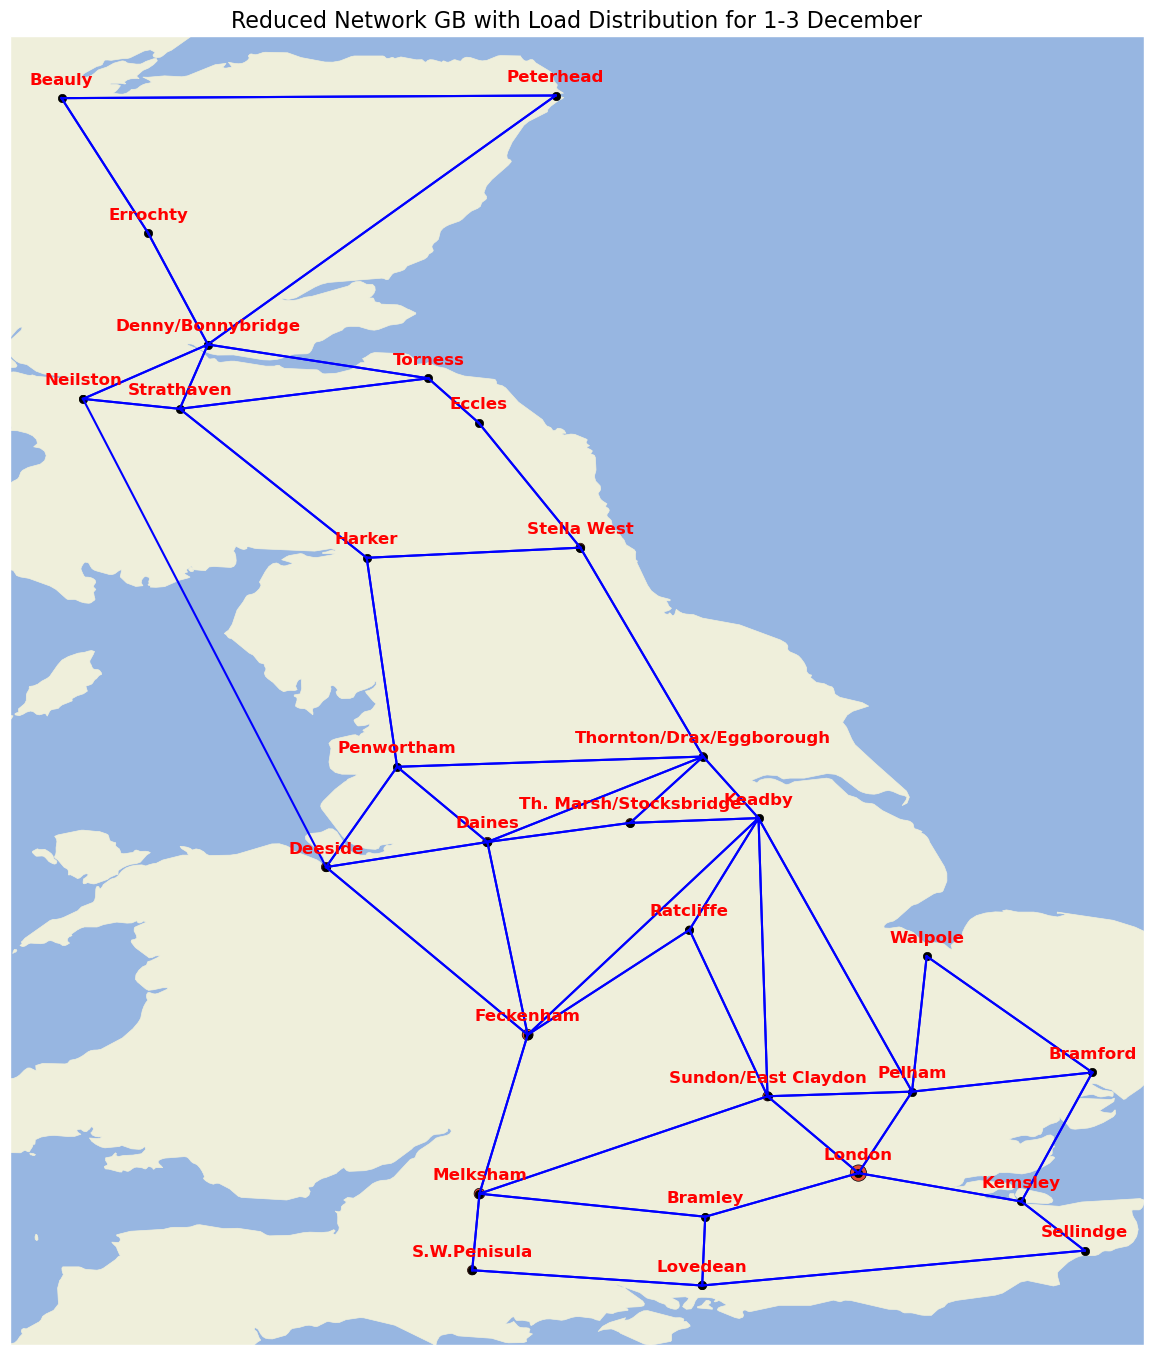

In [3]:
df_network = pd.read_csv('../data/network/buses.csv')[:29]
lon = df_network['x'].values
lat = df_network['y'].values

coordinates = np.zeros(shape=(len(lon), 2))
for i in range(len(lon)):
    coordinates[i][0] = lon[i]
    coordinates[i][1] = lat[i]

df_load = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0).iloc[:, :29]
sizes = df_load.sum(axis=0).values
marker_scaler = 0.0001

df_lines = pd.read_csv('../data/network/lines.csv', index_col=0)
df_buses = pd.read_csv('../data/network/buses.csv', index_col=0)

line_coordinates = []
for i in range(len(df_lines['bus0'].values)):

    bus0 = df_lines['bus0'].iloc[i]
    bus1 = df_lines['bus1'].iloc[i]
    bus0_coord = [df_buses['x'][bus0], df_buses['y'][bus0]]
    bus1_coord = [df_buses['x'][bus1], df_buses['y'][bus1]]
    line_coordinates.append([bus0_coord, bus1_coord])

fig = plt.figure()
fig.set_size_inches(15, 17)
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)

for i in range(len(df_lines['bus0'].values)):
    ax.plot([line_coordinates[i][0][0], line_coordinates[i][1][0]],
            [line_coordinates[i][0][1], line_coordinates[i][1][1]],
            c='blue')
print(len(sizes * marker_scaler))
ax.scatter(lon, lat, s=sizes * marker_scaler, edgecolors='black')
ax.scatter(lon, lat, c='black', edgecolors='black')
for i, txt in enumerate(df_buses[:29].index):
    ax.annotate(txt, (lon[i], lat[i]),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center',
                fontweight='extra bold',
                color='red',
                fontsize='large')

ax.set_title('Reduced Network GB with Load Distribution for 1-3 December', fontsize=16)

The ESPENI dataset is plotted for the entire dataset, over 2020, and over 01/01/2020.

In [4]:
df_loads = loads.read_historical_demand_data()
df_loads.rename(columns={'POWER_ESPENI_MW': 'load'}, inplace=True)
# add columns with year, month, and weekday name
df_loads['Year'] = df_loads.index.year
df_loads['Month'] = df_loads.index.month

Text(0, 0.5, 'Load [MW]')

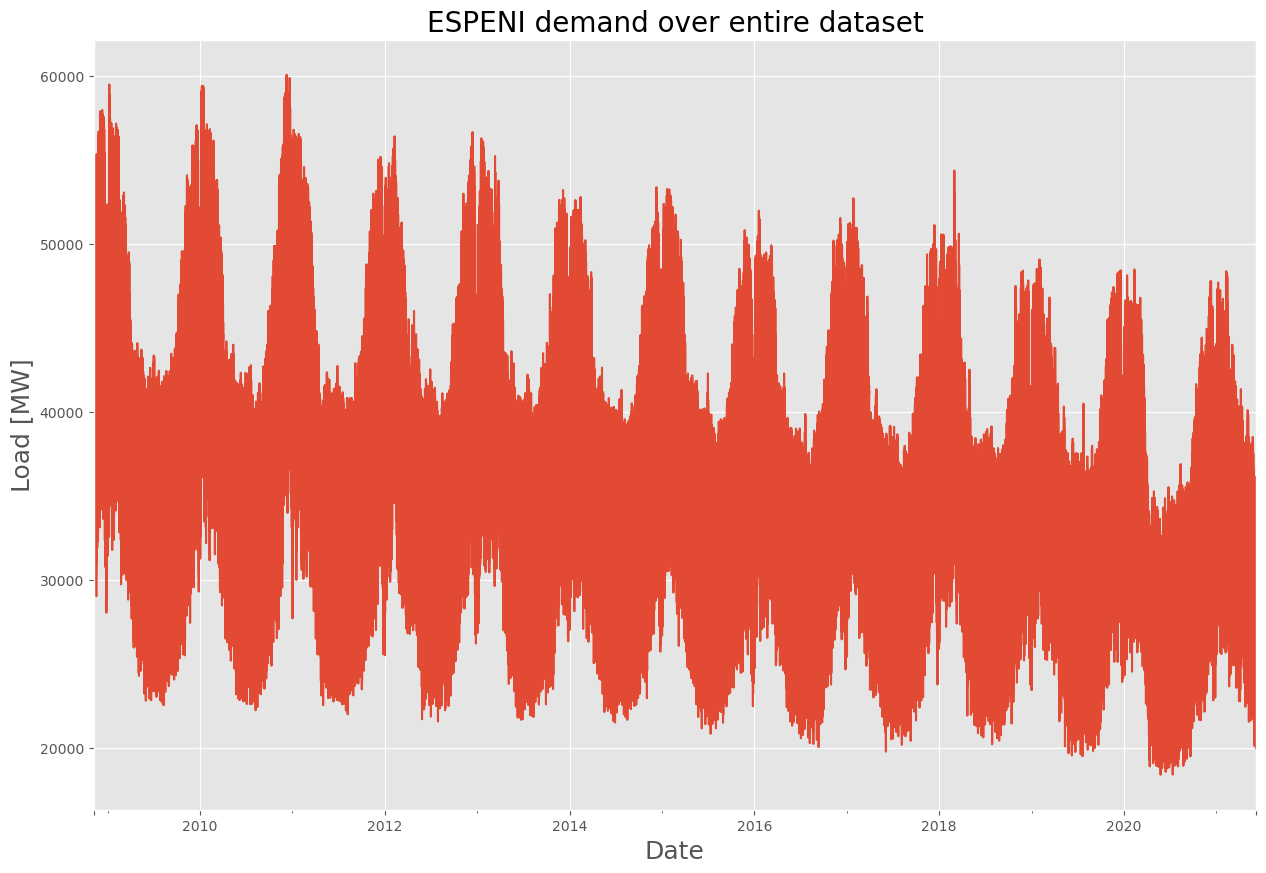

In [5]:
# Plot demand data
df_loads['load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over entire dataset', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

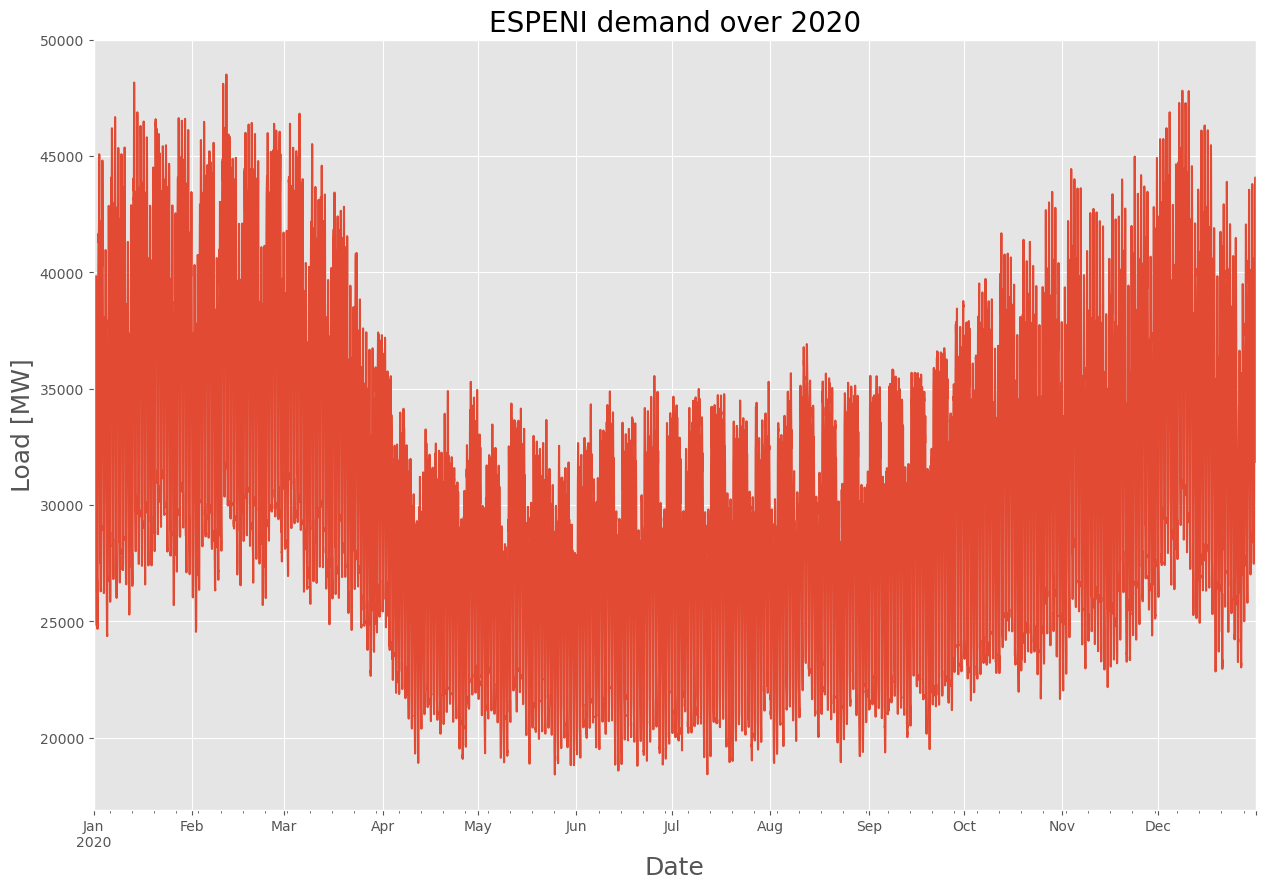

In [6]:
# Plot demand data
df_loads.loc['2020', 'load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

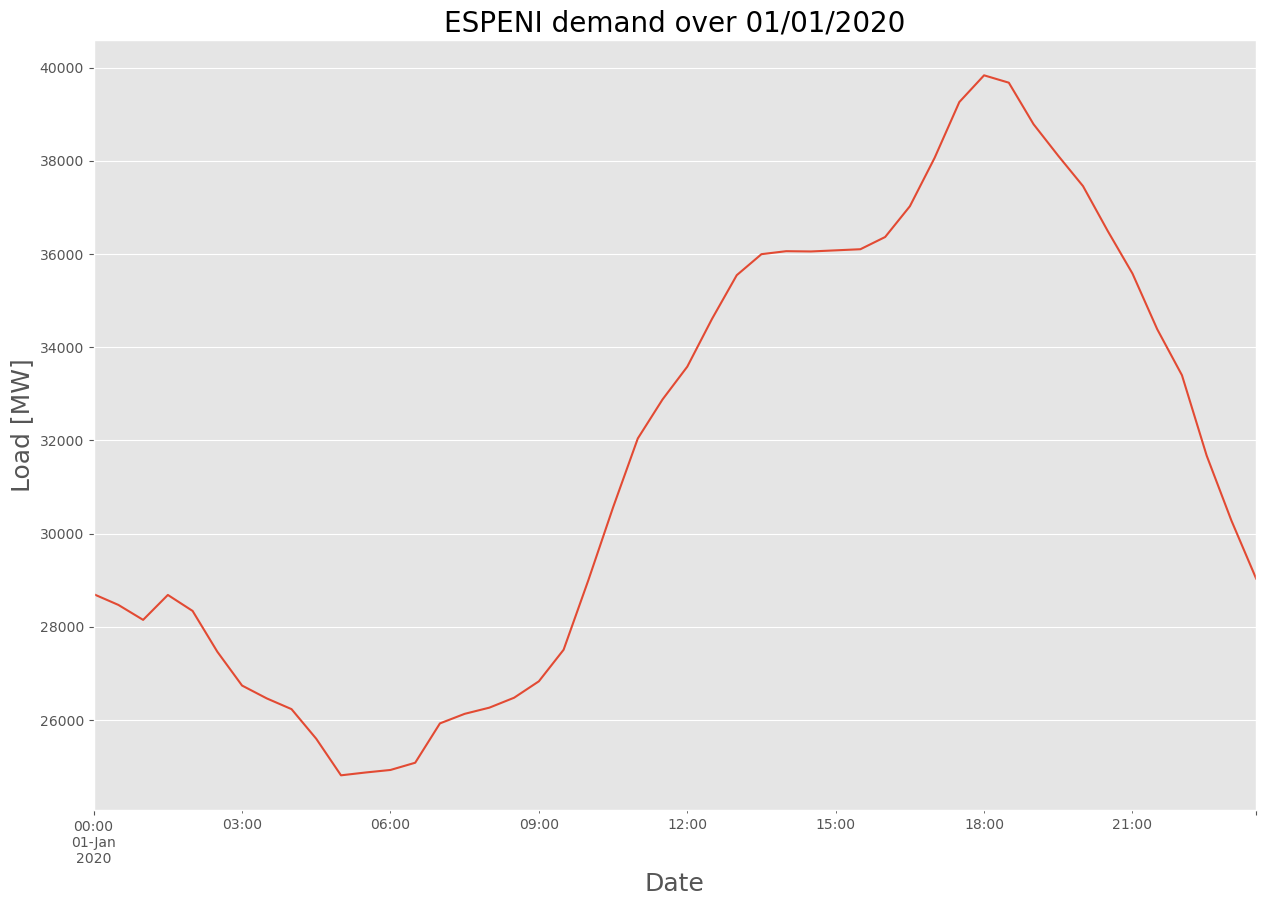

In [7]:
# Plot demand data
df_loads.loc['2020', 'load']['2020-01-01 00:00:00': '2020-01-01 23:30:00'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 01/01/2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Supply [kWh]')

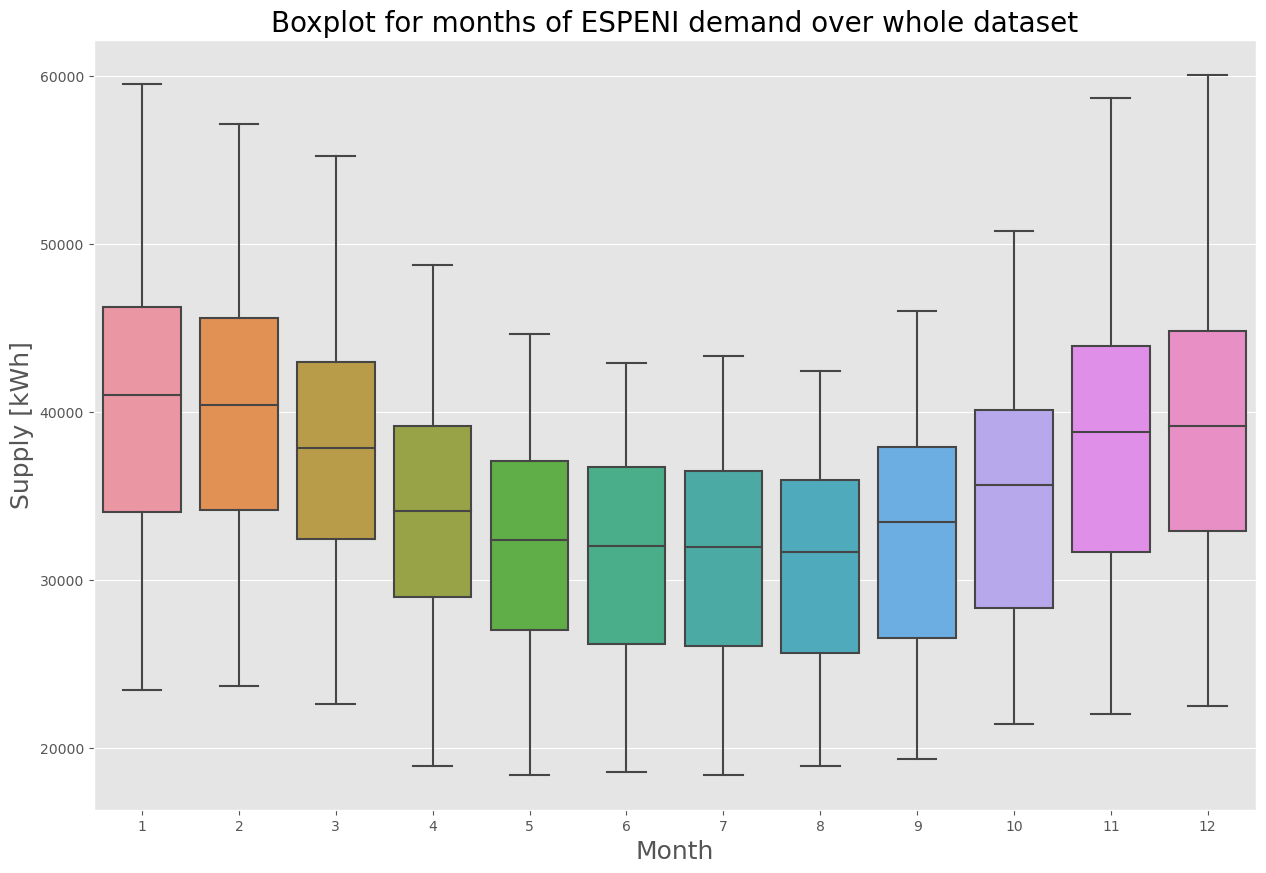

In [8]:
# Box plots over whole dataset for month values
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.boxplot(data=df_loads, x='Month', y='load')
ax.set_title('Boxplot for months of ESPENI demand over whole dataset', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

## Future data - FES2021

Future demand profiles are generated by scaling historical demand profiles to match the projected annual load from the FES2021 dataset. Different demand profiles from historical years can be chosen, and this along with the use of weather data forms the baseline year used to simulate future years. 

Distributions across buses are also obtained from FES2021 where data is available for distributions for the years 2020-2050 and all four scenarios.

In [9]:
start = '2050-01-01 00:00:00'
end = '2050-12-31 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1

year_baseline = 2019

loads.write_loads(year)
loads.write_loads_p_set(start, end, year, time_step, 'historical', year_baseline=year_baseline, scenario='Leading the Way', FES=2021)

df_loads = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0)
df_loads

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Bramford,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula
name,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,341.263639,553.867827,192.205723,1671.817912,1978.831018,599.021372,521.591265,146.815210,513.755558,3051.808876,...,1673.140512,1060.002419,3465.814738,4527.481837,1559.082530,10402.358246,1746.539953,1044.796593,2599.685988,3429.286465
2050-01-01 01:00:00,342.311057,555.567776,192.795647,1676.949109,1984.904510,600.859908,523.192150,147.265820,515.332393,3061.175586,...,1678.275769,1063.255812,3476.452128,4541.377731,1563.867716,10434.285500,1751.900490,1048.003316,2607.665029,3439.811742
2050-01-01 02:00:00,333.812550,541.774777,188.009138,1635.315740,1935.625577,585.942447,510.202935,143.609673,502.538311,2985.176229,...,1636.609463,1036.858516,3390.142761,4428.629612,1525.041802,10175.235025,1708.406314,1021.984692,2542.924912,3354.412041
2050-01-01 03:00:00,321.996177,522.596908,181.353947,1577.428457,1867.107857,565.201122,492.142654,138.526145,484.749345,2879.506274,...,1578.676385,1000.155560,3270.137708,4271.863962,1471.058021,9815.049714,1647.931754,985.808242,2452.909870,3235.671792
2050-01-01 04:00:00,308.988131,501.484966,174.027585,1513.703285,1791.680177,542.368049,472.261007,132.929946,465.166374,2763.179583,...,1514.900798,959.751138,3138.030234,4099.288613,1411.630017,9418.539982,1581.358380,945.983425,2353.816879,3104.956676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 19:00:00,499.618096,810.875691,281.393757,2447.581243,2897.055743,876.981557,763.622036,214.940964,752.150374,4467.920885,...,2449.517562,1551.868789,5074.035327,6628.341248,2282.533959,15229.300243,2556.976092,1529.607097,3806.002208,5020.557067
2050-12-31 20:00:00,471.124580,764.630970,265.345704,2307.994234,2731.834936,826.966779,720.072218,202.682754,709.254792,4213.112707,...,2309.820123,1463.364792,4784.660084,6250.323017,2152.359694,14360.764221,2411.150229,1442.372698,3588.943646,4734.231720
2050-12-31 21:00:00,435.110983,706.181225,245.062209,2131.567069,2523.008638,763.751974,665.028623,187.189325,655.038100,3891.054915,...,2133.253385,1351.502597,4418.912198,5772.537262,1987.829509,13263.001984,2226.837638,1332.115176,3314.598441,4372.338668


Text(0, 0.5, 'Load [MW]')

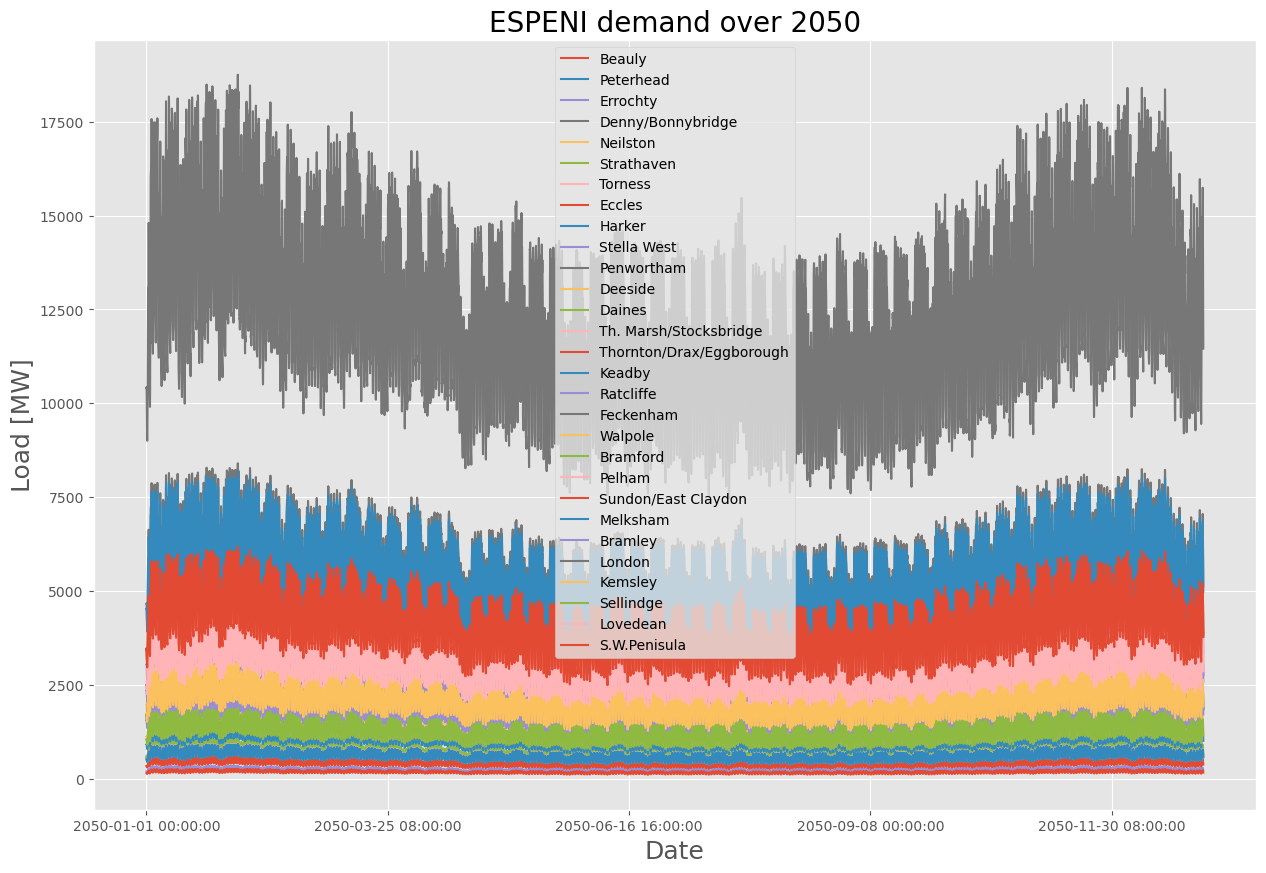

In [10]:
df_loads.plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [11]:
df_loads['Total'] = df_loads.sum(axis=1)
df_loads['Total']

name
2050-01-01 00:00:00    64159.805673
2050-01-01 01:00:00    64356.727022
2050-01-01 02:00:00    62758.952001
2050-01-01 03:00:00    60537.396178
2050-01-01 04:00:00    58091.798101
                           ...     
2050-12-31 19:00:00    93931.483709
2050-12-31 20:00:00    88574.515501
2050-12-31 21:00:00    81803.722753
2050-12-31 22:00:00    75767.552765
2050-12-31 23:00:00    70664.106055
Name: Total, Length: 8760, dtype: float64

Text(0, 0.5, 'Load [MW]')

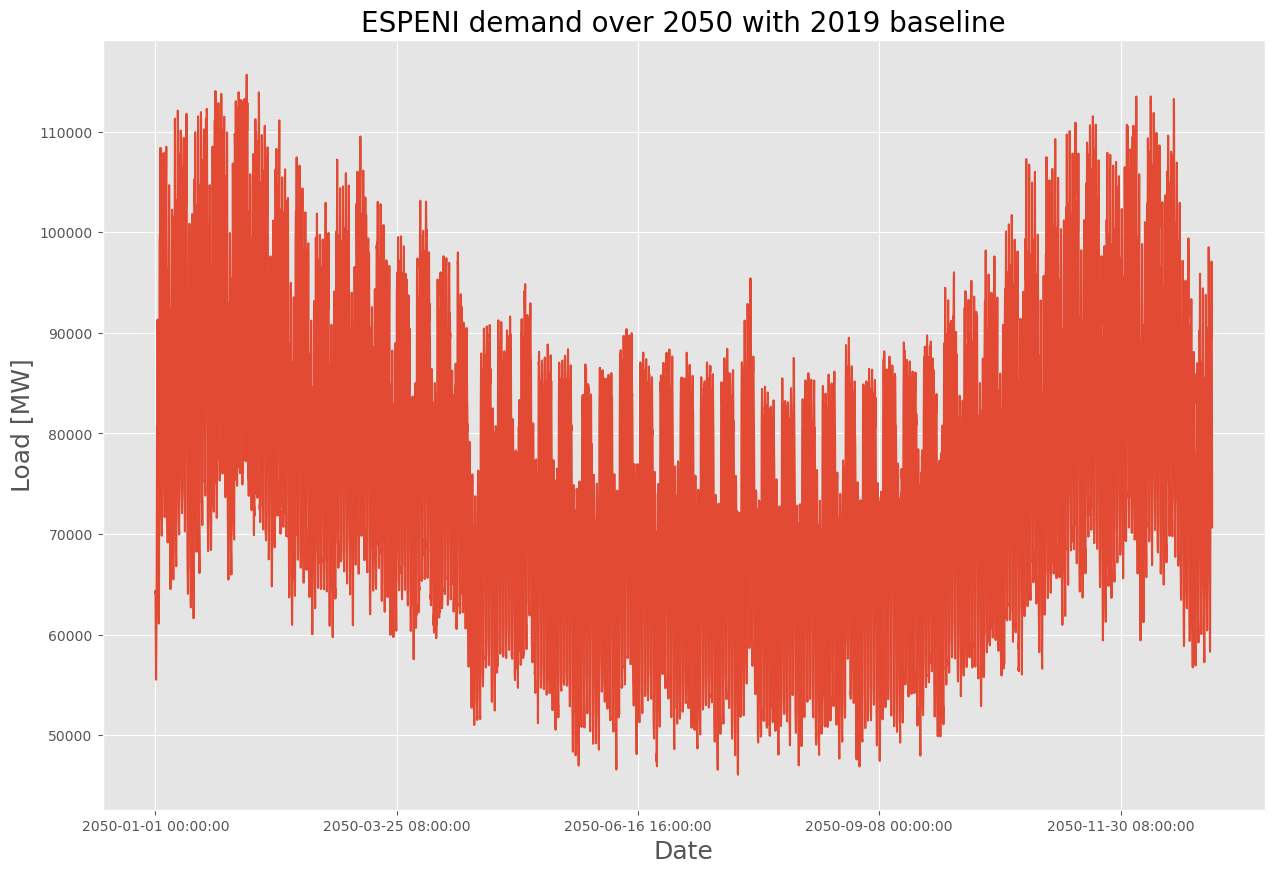

In [12]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050 with 2019 baseline', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [13]:
df_FES = pd.read_excel(
            '../data/FES2021/FES 2021 Data Workbook V04.xlsx',
            sheet_name='ED1', header=4, dtype=str)
df_FES_demand = df_FES.loc[df_FES['Data item'] == 'GBFES System Demand: Total']
scenario = 'Leading the Way'
df_FES_demand = df_FES_demand.loc[df_FES_demand['Scenario'] == scenario]
date = str(year) + '-01-01 00:00:00'
df_FES_demand.columns = df_FES_demand.columns.astype(str)
# future demand in GWh/yr
future_demand = df_FES_demand[date].values[0]
print(future_demand + ' GWh/year' + ' future total system demand in ' + str(year) + ' from FES2021 workbook')

686266 GWh/year future total system demand in 2050 from FES2021 workbook


In [14]:
print(str(round(df_loads['Total'].sum() / 2000, 0)) + ' GWh/year' + ' future total system demand in ' + str(year) + ' from checking dataframe by summing')

343133.0 GWh/year future total system demand in 2050 from checking dataframe by summing


In [15]:
df_loads

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula,Total
name,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,341.263639,553.867827,192.205723,1671.817912,1978.831018,599.021372,521.591265,146.815210,513.755558,3051.808876,...,1060.002419,3465.814738,4527.481837,1559.082530,10402.358246,1746.539953,1044.796593,2599.685988,3429.286465,64159.805673
2050-01-01 01:00:00,342.311057,555.567776,192.795647,1676.949109,1984.904510,600.859908,523.192150,147.265820,515.332393,3061.175586,...,1063.255812,3476.452128,4541.377731,1563.867716,10434.285500,1751.900490,1048.003316,2607.665029,3439.811742,64356.727022
2050-01-01 02:00:00,333.812550,541.774777,188.009138,1635.315740,1935.625577,585.942447,510.202935,143.609673,502.538311,2985.176229,...,1036.858516,3390.142761,4428.629612,1525.041802,10175.235025,1708.406314,1021.984692,2542.924912,3354.412041,62758.952001
2050-01-01 03:00:00,321.996177,522.596908,181.353947,1577.428457,1867.107857,565.201122,492.142654,138.526145,484.749345,2879.506274,...,1000.155560,3270.137708,4271.863962,1471.058021,9815.049714,1647.931754,985.808242,2452.909870,3235.671792,60537.396178
2050-01-01 04:00:00,308.988131,501.484966,174.027585,1513.703285,1791.680177,542.368049,472.261007,132.929946,465.166374,2763.179583,...,959.751138,3138.030234,4099.288613,1411.630017,9418.539982,1581.358380,945.983425,2353.816879,3104.956676,58091.798101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 19:00:00,499.618096,810.875691,281.393757,2447.581243,2897.055743,876.981557,763.622036,214.940964,752.150374,4467.920885,...,1551.868789,5074.035327,6628.341248,2282.533959,15229.300243,2556.976092,1529.607097,3806.002208,5020.557067,93931.483709
2050-12-31 20:00:00,471.124580,764.630970,265.345704,2307.994234,2731.834936,826.966779,720.072218,202.682754,709.254792,4213.112707,...,1463.364792,4784.660084,6250.323017,2152.359694,14360.764221,2411.150229,1442.372698,3588.943646,4734.231720,88574.515501
2050-12-31 21:00:00,435.110983,706.181225,245.062209,2131.567069,2523.008638,763.751974,665.028623,187.189325,655.038100,3891.054915,...,1351.502597,4418.912198,5772.537262,1987.829509,13263.001984,2226.837638,1332.115176,3314.598441,4372.338668,81803.722753


## Peak loads

Scaling the load profile according to the annual energy demand to generate future load profiles results in overestimation of peak demands.

The analysis below shows the FES2021 data peak to be 94.7 GW, but the generated future load profile have a peak of 115.8 GW. Applying a moving average can reduce the peak demand to 99.2 GW. A smoothing algorithm is not currently applied.

In [16]:
# Leading the way, 2050 Electricity System ACS (Average Cold Spell) Peak Demand GW
peak_FES = 94.7

In [17]:
df_loads.max()

Beauly                         615.216599
Peterhead                      998.491025
Errochty                       346.500880
Denny/Bonnybridge             3013.887246
Neilston                      3567.358338
Strathaven                    1079.892051
Torness                        940.304115
Eccles                         264.672657
Harker                         926.178212
Stella West                   5501.680407
Penwortham                    3079.210592
Deeside                       6183.406630
Daines                        6229.964398
Th. Marsh/Stocksbridge        5283.964378
Thornton/Drax/Eggborough      4510.199986
Keadby                        1648.798147
Ratcliffe                     4247.768895
Feckenham                     8401.868856
Walpole                       2023.679940
Bramford                      3016.271579
Pelham                        1910.930460
Sundon/East Claydon           6248.033810
Melksham                      8161.965290
Bramley                       2810

In [18]:
df_loads_smoothed = df_loads.rolling(48, min_periods=1).mean()
df_loads_smoothed.max()

Beauly                        526.487175
Peterhead                     854.483965
Errochty                      296.526897
Denny/Bonnybridge            2579.210288
Neilston                     3052.857182
Strathaven                    924.144953
Torness                       804.689044
Eccles                        226.500325
Harker                        792.600445
Stella West                  4708.202247
Penwortham                   2635.112394
Deeside                      5291.606716
Daines                       5331.449704
Th. Marsh/Stocksbridge       4521.886245
Thornton/Drax/Eggborough     3859.717784
Keadby                       1411.000743
Ratcliffe                    3635.135736
Feckenham                    7190.111911
Walpole                      1731.815325
Bramford                     2581.250740
Pelham                       1635.327104
Sundon/East Claydon          5346.913060
Melksham                     6984.808363
Bramley                      2405.286887
London          

Text(0, 0.5, 'Load [MW]')

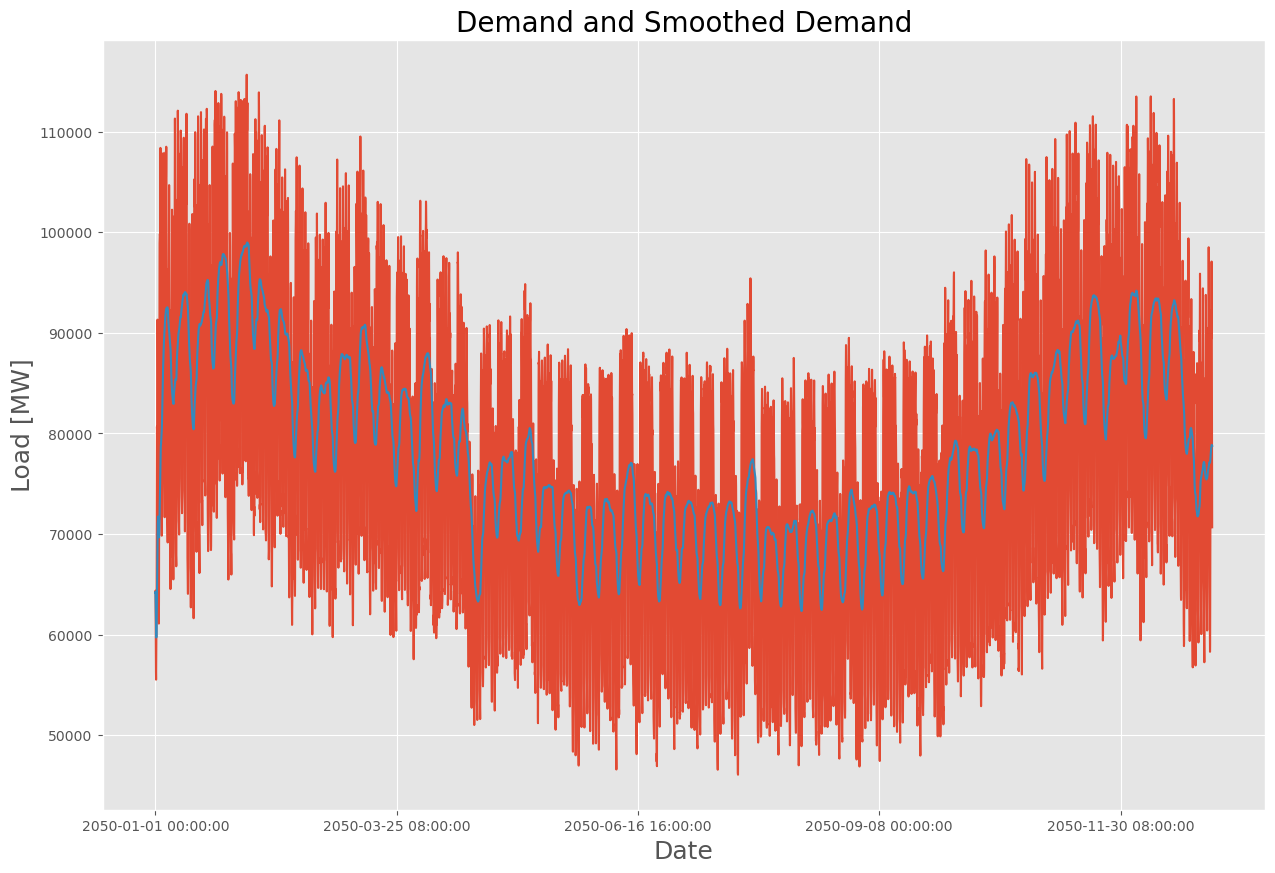

In [19]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
df_loads_smoothed['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('Demand and Smoothed Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

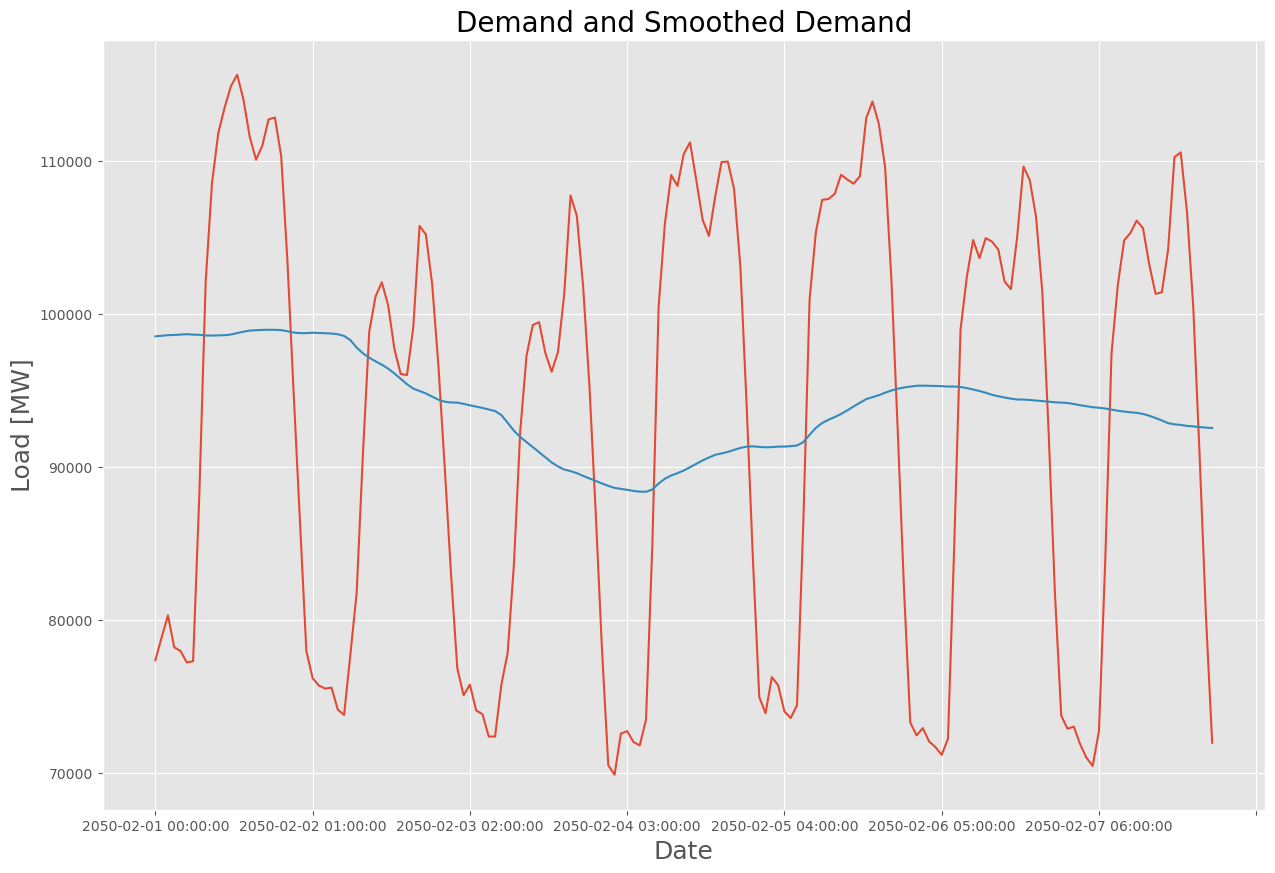

In [20]:
df_loads['Total']
date_from = '2050-02-01 00:00:00'
date_to = '2050-02-08 00:00:00'

df_loads['Total'].loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
df_loads_smoothed['Total'].loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
plt.title('Demand and Smoothed Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

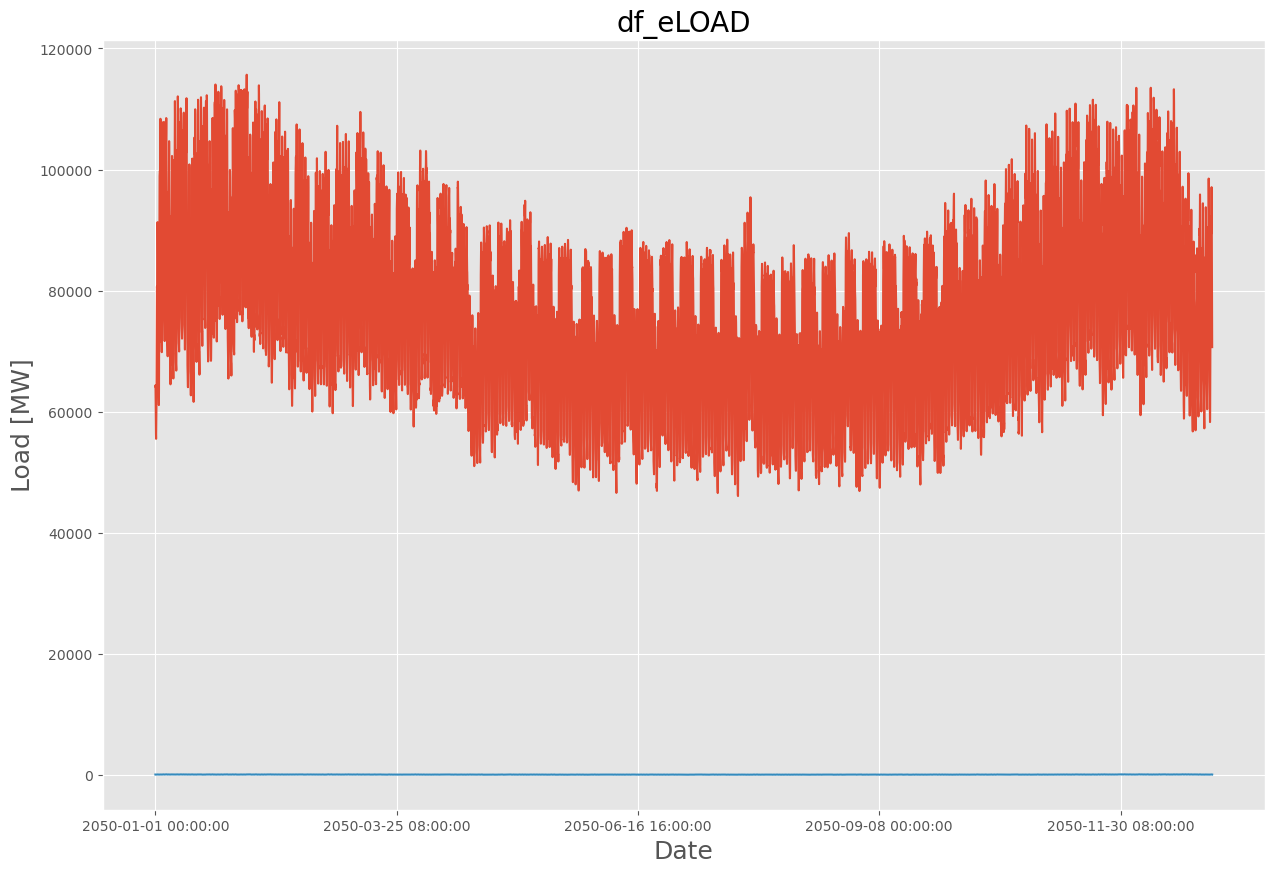

In [21]:
future_staffell_paper = pd.read_excel('../data/demand/egy_7649_mmc1.xlsb', sheet_name=None)
df_eLOAD = future_staffell_paper['ELOAD']['eLOAD Model (2050)'].drop([0,1,2,3,4,5])  # DESSTINEE is other demand model
df_eLOAD.index = df_loads.index
date_from = '2050-01-01 00:00:00'
date_to = '2050-12-31 23:30:00'

df_loads_downscaled = df_loads / 1000

df_loads['Total'].loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
df_eLOAD.loc[date_from:date_to].plot(linestyle='-', figsize=(15,10))
plt.title('df_eLOAD', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)